# 4. Auto Generated Agent Chat: Comic Story Group Chat


In [1]:
%%capture --no-stderr
# %pip install "pyautogen>=0.2.11"
# %pip install "matplotlib"

## Execution parameters

In [2]:
# Initiates the chat with 

start_message = """
As P0 I will start the discussion, I request to Team S to create a story for a ten panels sci-fi comic, the story must have at most 5 characters.
NEXT: S0.
"""

In [3]:
#set here the API Keys used by deepeval (autogen uses configurations in OAI_CONFIG_LIST file
import os
os.environ["OPENAI_API_KEY"] = "<your_api_key>"
os.environ["COHERE_API_KEY"] = "<your_api_key>"

In [4]:
#set groupchat max_round
max_round=20

In [5]:
#set the seed
seed = 42

In [6]:
#select which llm models you want to use for comic generation
enabled_models = [
    "gpt-3.5-turbo",
    "gpt-4",
    "command-nightly",
    "command-r",
]  

In [7]:
#select which llm models you want to use for output evaluation
enabled_evaluation_models = [
    "gpt-3.5-turbo",
    "gpt-4",
    "command-nightly",
    "command-r",
]

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [8]:
#create llm_configs list
import autogen

config_lists = {
    "command-nightly": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["command-nightly"],
        },
    ),
    "command-r": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["command-r"],
        },
     ),
    "gpt-3.5-turbo": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["gpt-3.5-turbo"],
        },
    ),
    "gpt-4": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["gpt-4"],
        },
    ),
    "mistral-7B": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["mistral-7B"],
        },
    ),
}

llm_configs = []
for enabled_model in enabled_models:
    llm_configs.append({"config_list": config_lists[enabled_model], "cache_seed": seed})

## Import Libraries

In [9]:
import random

import matplotlib.pyplot as plt
import networkx as nx

from time import sleep
from openai import InternalServerError

import autogen
from autogen import Agent
from autogen.agentchat.conversable_agent import ConversableAgent
from autogen.agentchat.assistant_agent import AssistantAgent
from autogen.agentchat.groupchat import GroupChat
from autogen.graph_utils import visualize_speaker_transitions_dict

In [10]:
from openai import InternalServerError
from IPython.display import clear_output

## Construct Agents - Communications Graph

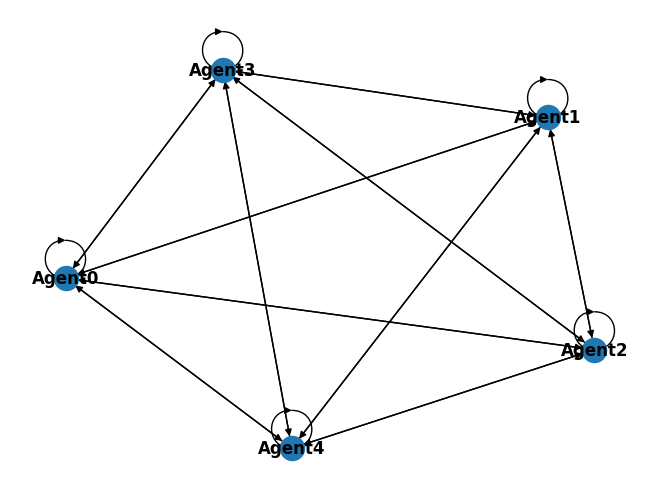

In [11]:
# Default transition paths, the current GroupChat class allows transition to any agent
agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(5)]
allowed_speaker_transitions_dict = {agent: [other_agent for other_agent in agents] for agent in agents}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

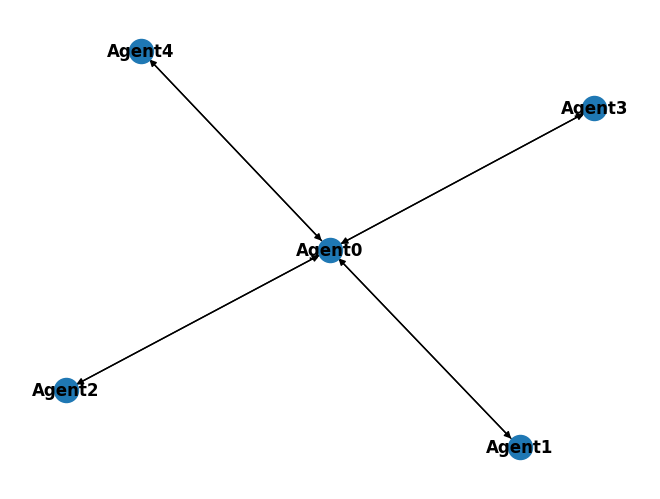

In [12]:
# Hub and Spoke
agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(5)]
allowed_speaker_transitions_dict = {
    agents[0]: [agents[1], agents[2], agents[3], agents[4]],
    agents[1]: [agents[0]],
    agents[2]: [agents[0]],
    agents[3]: [agents[0]],
    agents[4]: [agents[0]],
}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

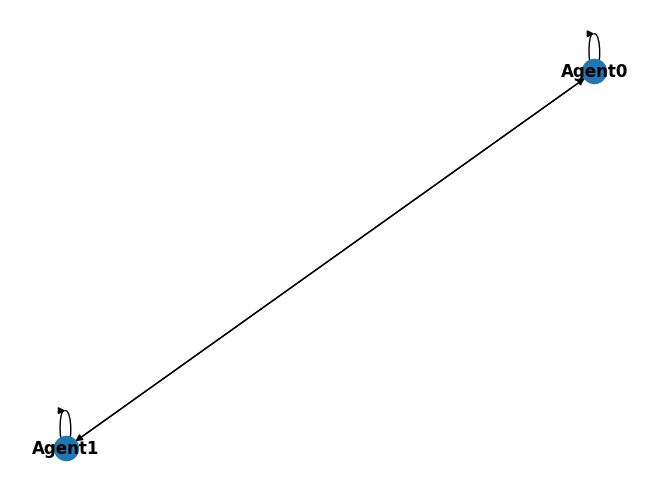

In [13]:
# Think aloud and debate
agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(2)]
allowed_speaker_transitions_dict = {
    agents[0]: [agents[0], agents[1]],
    agents[1]: [agents[0], agents[1]],
}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

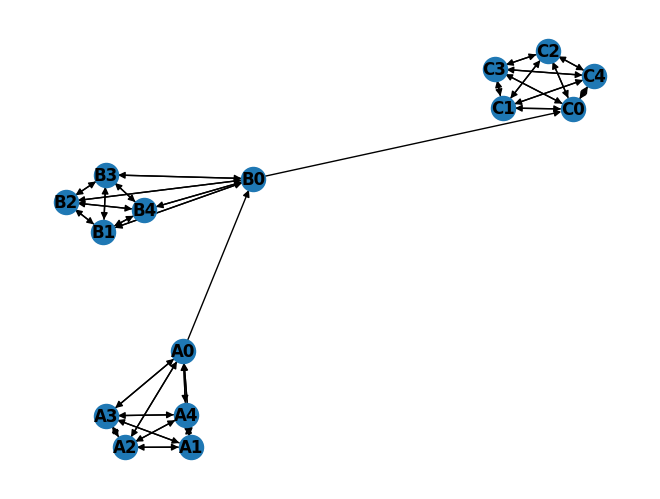

In [14]:
# Sequential Team Operations

# Create an empty directed graph
speaker_transitions_dict = {}
teams = ["A", "B", "C"]
team_size = 5


def get_agent_of_name(agents, name) -> ConversableAgent:
    for agent in agents:
        if agent.name == name:
            return agent


# Create a list of 15 agents 3 teams x 5 agents
agents = [ConversableAgent(name=f"{team}{i}", llm_config=False) for team in teams for i in range(team_size)]

# Loop through each team and add members and their connections
for team in teams:
    for i in range(team_size):
        member = f"{team}{i}"
        # Connect each member to other members of the same team
        speaker_transitions_dict[get_agent_of_name(agents, member)] = [
            get_agent_of_name(agents, name=f"{team}{j}") for j in range(team_size) if j != i
        ]

# Team leaders connection
print(get_agent_of_name(agents, name="B0"))
speaker_transitions_dict[get_agent_of_name(agents, "A0")].append(get_agent_of_name(agents, name="B0"))
speaker_transitions_dict[get_agent_of_name(agents, "B0")].append(get_agent_of_name(agents, name="C0"))

visualize_speaker_transitions_dict(speaker_transitions_dict, agents)

## Comic group chat - Story creation - Team Operations

In [15]:
system_message = """
Your name is {node_id}.
This is a group chat, do not respond as the speaker named in the NEXT tag if your name is not in the NEXT tag. Instead, suggest a relevant team leader to handle the mis-tag, with the NEXT: tag.
The list of agents in the group chat are [P0, P1, P2, S0, S1, S2, C0, C1, C2].

Your first character of your name is your team, and your second character denotes that you are a team leader if it is 0.
Team members can only talk within the team Only a team leader can talk to team leaders of other teams but not team members of other teams.
Team members must brainstorming with their team leader.

You can use NEXT: to suggest the next speaker. You can only suggest one agent from the list of agents, i.e., do not suggest P3 because P3 is not from the list of players.
   
These are the roles of each team:
   - Team S:
     S0 is responsible for team S only.
     S0 create the first draft story and talks to other members of his team who cooperate in creating the story.
     Team S members are story_assistants, some helpful assistants that can suggest stories to a user who wants to write a comic.
     Team S will receive suggestions or advice from other teams. S0 must ensure that the finally story integrates the suggestions from other teams.
     The story must contain full dialogues to be reported in the comic.
     For every panel provide two sections, an image description and the full dialogues to fit in.
     Dialogues must be short.
     CONSTRAINTS: The team leader S0 must communicate to the other team leaders only complete stories, including all the comic panels.
     CONSTRAINTS: The team leader S0 submit to other teams messages containing the story with the following format:
     '''
     TITLE: the story title
     ABSTRACT: short story summary

     PROTAGONISTS: names and short descritpions of the protagonists

     PANEL START progressive panel number
      IMAGE_DESCRIPTION: the panel image description
      IMAGE_DIALOGUES: the panel dialogues specifying the character who says them
     PANEL END progressive panel number
     '''
     
   - Team P:
     P0 is responsible for team P only.
     Team P mission is to coordinate a comic story production process and to stimulate discussion between the team leaders.
     Team P must ensure that the final comic story meets the requests and that it also satisfies the suggestions provided by team C.
     P0 talks with the other members of his team to agree on the message to use to interact with the other team leaders.
     CONSTRAINTS: When the story produced by team S has the approval of team C, P0 can end the discussion using TERMINATE.
   - Team C:
     C0 is responsible for team C only.
     C0 talks to other members of his team who cooperate in evaluate the story proposed by Team C.
     Team C members are the critical_assistants, some helpful assistants that can review comic stories,
     providing feedback on important/critical tips about the characterization of the story's protagonists.
     If the story already has a good characterization, they can mention that the story is satisfactory, with rationale.
     The team leader C0 must lead the internal team discussion to formulate a common response to communicate to the other team leaders.


 Once the team leader know the response agreed within his team he can communicate it to the other team leaders and suggest the next speaker.
 Use NEXT: to suggest the next speaker, e.g., NEXT: C0

CONSTRAINTS: You MUST NOT suggest yourself as next speaker.
CONSTRAINTS: When the story produced by team S has the approval of team C, P0 must end the discussion using TERMINATE.

 """

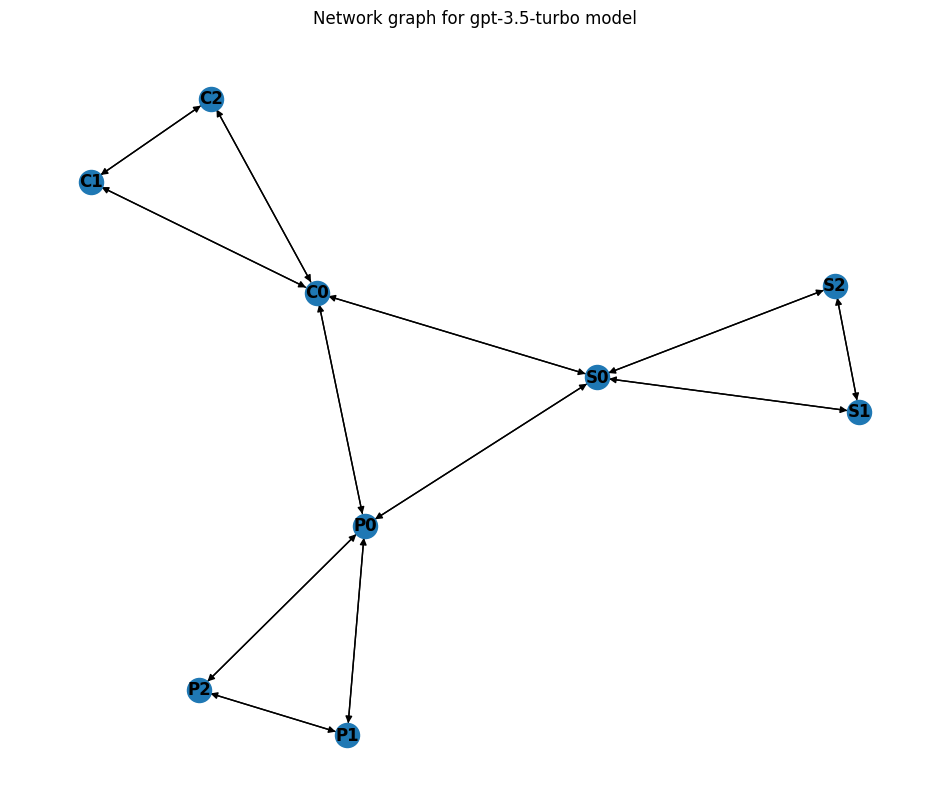

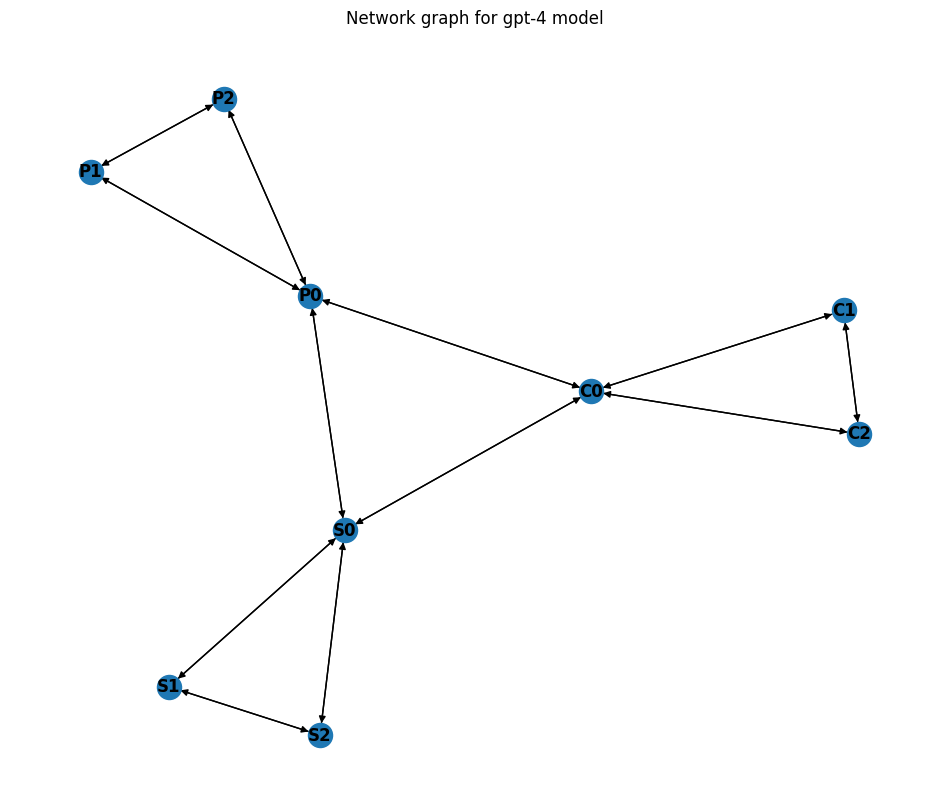

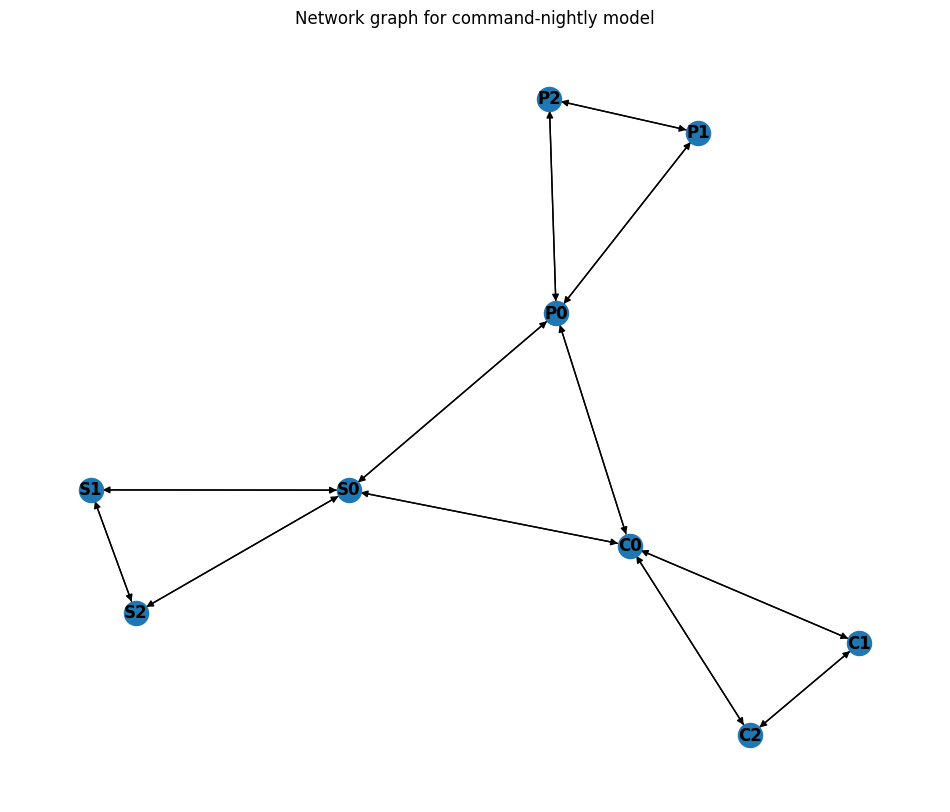

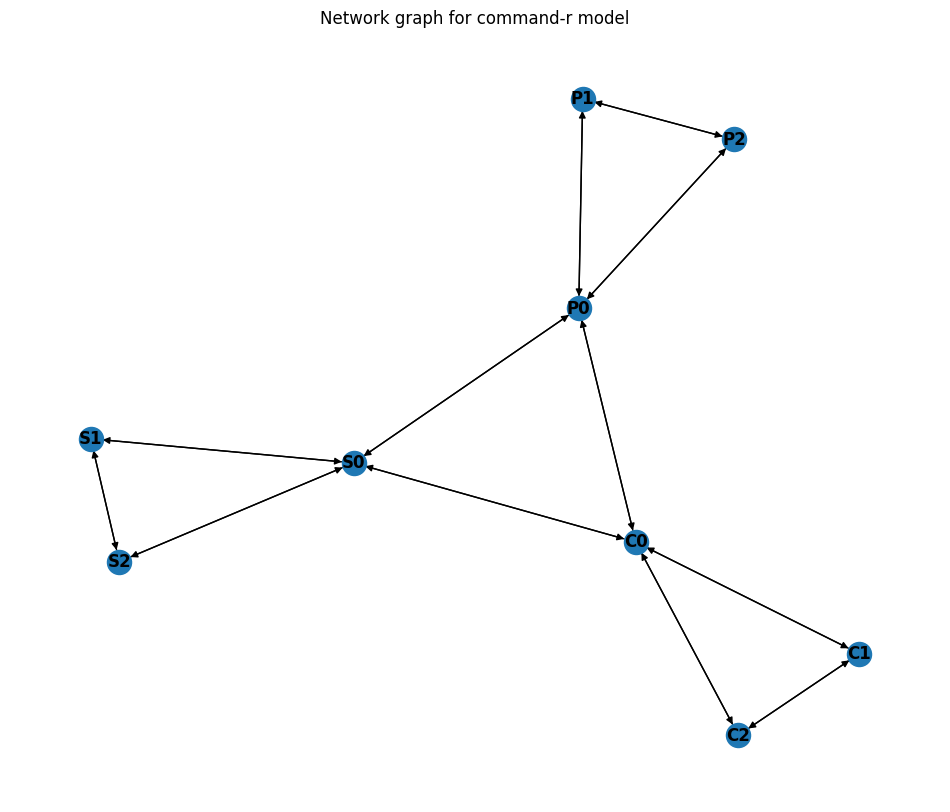

In [16]:
# Teams definitions
teams = []
speaker_transitions_dicts = []
for llm_config in llm_configs:
    # Create an empty directed graph
    agents = []
    speaker_transitions_dict = {}
    secret_values = {}
    
    # Outer loop for prefixes 'A', 'B', 'C'
    for prefix in ["P", "S", "C"]: # P="Primary" S="Story", C="Critic"]:
        # Add 3 nodes with each prefix to the graph using a for loop
        for i in range(3):
            node_id = f"{prefix}{i}"
            #print (system_message.format(node_id=node_id, prefix=prefix, i=i))
            # Create an AssistantAgent for each node (assuming AssistantAgent is a defined class)
            agents.append(
                AssistantAgent(
                    name=node_id,
                    system_message=system_message.format(node_id=node_id, prefix=prefix, i=i),                      
                    llm_config=llm_config,
                )
            )
            speaker_transitions_dict[agents[-1]] = []
    
        # Add edges between nodes with the same prefix using a nested for loop
        for source_node in range(3):
            source_id = f"{prefix}{source_node}"
            for target_node in range(3):
                target_id = f"{prefix}{target_node}"
                if source_node != target_node:  # To avoid self-loops
                    speaker_transitions_dict[get_agent_of_name(agents, source_id)].append(
                        get_agent_of_name(agents, name=target_id)
                    )
    
    # Adding edges between teams
    speaker_transitions_dict[get_agent_of_name(agents, "P0")].append(get_agent_of_name(agents, name="S0"))
    speaker_transitions_dict[get_agent_of_name(agents, "P0")].append(get_agent_of_name(agents, name="C0"))
    speaker_transitions_dict[get_agent_of_name(agents, "S0")].append(get_agent_of_name(agents, name="P0"))
    speaker_transitions_dict[get_agent_of_name(agents, "S0")].append(get_agent_of_name(agents, name="C0"))
    speaker_transitions_dict[get_agent_of_name(agents, "C0")].append(get_agent_of_name(agents, name="P0"))
    speaker_transitions_dict[get_agent_of_name(agents, "C0")].append(get_agent_of_name(agents, name="S0"))

    teams.append(agents)
    speaker_transitions_dicts.append(speaker_transitions_dict)

    # Visualization only
    graph = nx.DiGraph()
    
    # Add nodes
    graph.add_nodes_from([agent.name for agent in agents])
    
    # Add edges
    for key, value in speaker_transitions_dict.items():
        for agent in value:
            graph.add_edge(key.name, agent.name)
    
    # Visualize
    
    
    # Draw the graph with secret values annotated
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(graph)  # positions for all nodes
    plt.title(f'Network graph for {llm_config["config_list"][0]["model"]} model')
    
    # Draw nodes with their colors
    nx.draw(graph, pos, with_labels=True, font_weight="bold")

    plt.show()

In [17]:
# Termination message detection

def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False


# Terminates the conversation when TERMINATE is detected.
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Terminator admin.",
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
    human_input_mode="NEVER",
)

#no user proxy
#agents.append(user_proxy)

In [18]:
#custom speaker selection

def custom_speaker_selection_func(last_speaker: Agent, groupchat: autogen.GroupChat):
    """Define a customized speaker selection function.
    A recommended way is to define a transition for each speaker in the groupchat.

    Returns:
        Return an `Agent` class or a string from ['auto', 'manual', 'random', 'round_robin'] to select a default method to use.
    """
    messages = groupchat.messages

    #print (messages[-1])

    if len(messages) <= 1:
        # First message goes to S0
        return agents[3]

    if last_speaker is agents[0]: # "P0"
        if "NEXT: S" in messages[-1]["content"]:
            # If the last message has redirect to Story group, let S0 to speak
            return agents[3] # "S0"
        elif "NEXT: C" in messages[-1]["content"]:
            # If the last message has redirect to Critic group, let C0 to speak
            return agents[6] # "C0"
        elif "NEXT: P1" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[1] # "P1"
        elif "NEXT: P2" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[2] # "P2"
    elif last_speaker is agents[1]: #P1
        if "NEXT: P2" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[2]     
        else:
            # All other cases redirect P1 and P2 messages to P0
            return agents[0]
    elif last_speaker is agents[2]: #P2
        if "NEXT: P1" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[1]     
        else:
            # All other cases redirect P1 and P2 messages to P0
            return agents[0]

    elif last_speaker is agents[3]: # "S0"
        if "NEXT: P" in messages[-1]["content"]:
            # If the last message has redirect to Primary group, let P0 to speak
            return agents[0] # "P0"
        elif "NEXT: C" in messages[-1]["content"]:
            # If the last message has redirect to Critic group, let C0 to speak
            return agents[6] # "C0"
        elif "NEXT: S1" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[4] # "S1"
        elif "NEXT: S2" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[5] # "S2"
    elif last_speaker is agents[4]: #S1
        if "NEXT: S2" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[5]     
        else:
            # All other cases redirect S1 and S2 messages to S0
            return agents[3]
    elif last_speaker is agents[5]: #S2
        if "NEXT: S1" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[4]     
        else:
            # All other cases redirect S1 and S2 messages to S0
            return agents[3]

    elif last_speaker is agents[6]: # "C0"
        if "NEXT: P" in messages[-1]["content"]:
            # If the last message has redirect to Primary group, let P0 to speak
            return agents[0] # "P0"
        elif "NEXT: S" in messages[-1]["content"]:
            # If the last message has redirect to Story group, let S0 to speak
            return agents[3] # "C0"
        elif "NEXT: C1" in messages[-1]["content"]:
            # If the last message has redirect to internal tream member, let member to speak
            return agents[7] # "C1"
        elif "NEXT: C2" in messages[-1]["content"]:
            # If the last message has redirect to internal tream member, let member to speak
            return agents[8] # "C2"
    elif last_speaker is agents[7]: #C1
        if "NEXT: C2" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[8]     
        else:
            # All other cases redirect C1 and C2 messages to C0
            return agents[6]
    elif last_speaker is agents[8]: #C2
        if "NEXT: C1" in messages[-1]["content"]:
            # If the last message has redirect to internal team member, let member to speak
            return agents[7]     
        else:
            # All other cases redirect C1 and C2 messages to C0
            return agents[6]
    else:
        # if nothing matches, always let P0 to speak
        return agents[6]
        #return "random"

## Start Story Group Chats

In [19]:
#Get last story produced:
def extract_story(groupchat: autogen.GroupChat) -> str:
    """
    Extracts the story from the last message of an agent.
    """
    story = []
    for message in groupchat.messages:
        story.append(message["content"])
    full_story = '\nMessage:\n'.join(story)
    return full_story

In [20]:
stories = []
for llm_config, agents, speaker_transitions_dict in zip (llm_configs, teams, speaker_transitions_dicts):
    print("==============================")
    print("Starting Chat using model: ", llm_config['config_list'][0]['model'])
    print("==============================")
    groupchat = GroupChat(
        agents=agents,
        messages=[],
        max_round=max_round,
        allowed_or_disallowed_speaker_transitions=speaker_transitions_dict,
        speaker_transitions_type="allowed",
        speaker_selection_method=custom_speaker_selection_func,
    )
    
    
    # Create the manager
    manager = autogen.GroupChatManager(
        groupchat=groupchat,
        llm_config=llm_config,
        code_execution_config=False,
        is_termination_msg=is_termination_msg
    )
    
    #reset agents
    for agent in agents:
        agent.reset()
    
    while True:
        try:
            agents[0].initiate_chat(
                manager,
                message=start_message,
            )
            break
        except InternalServerError as e:
            #wait to respect API limits
            print(type(e))
            print(e)
            sleep(55)
            clear_output()

    stories.append(extract_story(groupchat))

    print("==============================")
    print("Chat Ends")
    print("==============================")

Starting Chat using model:  gpt-3.5-turbo
P0 (to chat_manager):


As P0 I will start the discussion, I request to Team S to create a story for a ten panels sci-fi comic, the story must have at most 5 characters.
NEXT: S0.


--------------------------------------------------------------------------------
S0 (to chat_manager):

Understood, Team S, let's brainstorm and come up with a sci-fi story for the comic in ten panels with at most five characters. Any initial ideas?
NEXT: S1

--------------------------------------------------------------------------------
S1 (to chat_manager):

I think I have an idea. What if we create a story about a group of space explorers who discover a mysterious alien artifact that grants them superhuman abilities, but at a cost? The artifact starts corrupting their minds and personalities as they use its powers. Does this sound like a good starting point? 
NEXT: S2

--------------------------------------------------------------------------------
S2 (to chat_m

## Evaluate the results
Evaluation

In [21]:
# import deepeval and dependencies
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval
from langchain_cohere import ChatCohere
# from langchain_community.chat_models import ChatCohere #deprecated
from deepeval.models.base_model import DeepEvalBaseLLM

/home/hibiki/.conda/envs/pyautogen/lib/python3.10/site-packages/deepeval/__init__.py:42: UserWarning: You are using deepeval version 0.21.34, however version 0.21.36 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [22]:
# disable warnings to silent deepeval ipywidgets check
import warnings
warnings.filterwarnings('ignore')

In [23]:
#Define a custom evaluation model class (using Cohere command-nightly or command-r)

from langchain_community.chat_models import ChatCohere
from deepeval.models.base_model import DeepEvalBaseLLM

class Cohere(DeepEvalBaseLLM):
    def __init__(
        self,
        model
    ):
        self.model = model

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        return chat_model.invoke(prompt).content

    async def a_generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        res = await chat_model.ainvoke(prompt)
        return res.content

    def get_model_name(self):
        return "Custom Cohere Model"


In [24]:
# define here instances of llm model used by deepeval for evaluation
evaluation_models = {
    "gpt-3.5-turbo": "gpt-3.5-turbo",
    "gpt-4": "gpt-4",
    "command-nightly": Cohere(ChatCohere(model="command-nightly", seed=seed)),
    "command-r":       Cohere(ChatCohere(model="command-r", seed=seed)),
}

In [25]:
for enabled_evaluation_model in enabled_evaluation_models:
    eval_model_instance = evaluation_models[enabled_evaluation_model]
    for provided_output, enabled_model in zip(stories, enabled_models):
        print("\n==============================")
        print(f"Using evaluating model: {enabled_evaluation_model} to evaluate output from LLM: {enabled_model}")
        test_case = LLMTestCase(input=(system_message+start_message), actual_output=provided_output)
        coherence_metric = GEval(
            model=eval_model_instance,  # API usage
            name="Comic evaluation",
            # NOTE: you can only provide either criteria or evaluation_steps, and not both
            #criteria="Comic evaluation - the collective quality of comic panels, characters and images descriptions",
            evaluation_steps=[
                "Check whether the output format in 'actual output' aligns with that required in 'input'",
                "Check whether the sentences in 'actual output' aligns with that in 'input'",
                "Evaluate the general quality of comic panels in 'actual output'",
                "Evaluate the general quality of characters descriptions in 'actual output'",
                "Evaluate the general quality of images descriptions in 'actual output'",
                "Be critical and emphasize the negative aspects of your evaluation",
            ],
            evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
        )
    
        coherence_metric.measure(test_case)
        print(f" Score: {coherence_metric.score}")
        print(f"Reason: {coherence_metric.reason}")
        print("==============================")

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Using evaluating model: gpt-3.5-turbo to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.851683270596497
Reason: The text aligns with the input criteria and provides a detailed narrative following the evaluation steps, but there are minor inconsistencies and repetitions in the dialogues and descriptions.

Using evaluating model: gpt-3.5-turbo to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9333747135145062
Reason: The actual output aligns perfectly with the evaluation steps provided. The story created by Team S for the sci-fi comic meets all the criteria outlined, including the format, alignment with input, quality of comic panels, character descriptions, and image descriptions. The story demonstrates creativity, cohesion, and engagement, fulfilling the requirements set out in the evaluation steps.

Using evaluating model: gpt-3.5-turbo to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8214794681056942
Reason: The output aligns well with the input criteria, including creating a sci-fi story with up to 5 characters in ten panels and following the format for panel descriptions and dialogues. The story draft is detailed and well-structured, showcasing creativity and adherence to the given constraints.

Using evaluating model: gpt-3.5-turbo to evaluate output from LLM: command-r


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.4779540795682419
Reason: The text aligns with the input and provides relevant information. However, it lacks specific details and examples to support the evaluation.

Using evaluating model: gpt-4 to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9144343190556222
Reason: The actual output is in line with the 'input' instructions. The format, story content, and character descriptions are appropriate. The team members are actively brainstorming and developing the story together, and the team leader is ensuring that the output is formatted correctly and complete. The critique is focused on the quality of comic panels, character descriptions, and image descriptions, which are all well done in this case.

Using evaluating model: gpt-4 to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.95
Reason: The actual output closely follows the input specifications, with characters communicating within their teams and between team leaders. The story development, characters' descriptions, and images' descriptions are well executed. The teams also follow the rules about suggesting the next speaker and never suggesting themselves. However, there is room for improvement in terms of providing more detailed image descriptions and character dialogues.

Using evaluating model: gpt-4 to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9177171496500975
Reason: The actual output closely follows the evaluation criteria with the output format aligning with that required in 'input'. The sentences in 'actual output' also follow the 'input' instructions. The general quality of comic panels, characters descriptions, and images descriptions, in 'actual output' is high. However, there is slight room for improvement in the quality of the dialogues in the comic panels.

Using evaluating model: gpt-4 to evaluate output from LLM: command-r


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.979647006056323
Reason: The output perfectly matches the input, follows all the instructions accurately and adheres to the constraints of the task. The message structure, character roles, and conversation flow are all maintained correctly.

Using evaluating model: command-nightly to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8
Reason: While the 'actual output' generally follows the required format and includes the specified sentences, there are some inconsistencies in the evaluation criteria. The story and panel descriptions are well-crafted and engaging, but the character and image descriptions could provide more detail to fully meet the criteria. The story development and panel narratives showcase creativity and effective collaboration, but there is room for enhancing the depth and complexity of certain elements to achieve a higher score.

Using evaluating model: command-nightly to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8
Reason: While the 'actual output' adheres to the required format and most sentences are accurately reproduced, there are some minor deviations in the sentences and structure. The evaluation of the comic panels, character, and image descriptions reveals a generally high quality, but there is room for improvement in terms of creativity and uniqueness. The story follows a predictable arc, and the characters could benefit from more distinct personalities and interactions to make the story more engaging.

Using evaluating model: command-nightly to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.7
Reason: While the 'actual output' follows the required format and the sentences are generally aligned, there are some inconsistencies in the evaluation criteria. The comic panels and character/image descriptions show creativity and an understanding of the task, but there are areas for improvement. The story draft lacks a clear, concise title and abstract, and the character descriptions could be more detailed to enhance the reader's visualization. The dialogue is somewhat generic and could be made more engaging to match the intriguing premise.

Using evaluating model: command-nightly to evaluate output from LLM: command-r


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.4
Reason: While the 'Actual Output' follows the general format and sentence structure of the 'Input', there are issues with the specific role instructions and the overall clarity. The 'Actual Output' does not properly address the complex set of constraints and requirements for each team, particularly the critical role of Team C in evaluating the story. The evaluation criteria for Team C, including the characterization and common response formulation, are not evident in the output. The 'Actual Output' also lacks detail in describing the process of internal team discussions and the specific steps for communicating responses between team leaders. These omissions impact the quality of the comic panels, character, and image descriptions.

Using evaluating model: command-r to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.7
Reason: While the 'actual output' follows the required format and the sentences are generally aligned, the evaluation criteria have not been fully met. The comic panels and character/image descriptions show creativity and an understanding of the story, but there is room for improvement in terms of detail and originality. The panels could benefit from more intricate details to enhance the visual impact, and the character/image descriptions could be more unique to showcase the story's creativity.

Using evaluating model: command-r to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8
Reason: While the 'actual output' follows the required format and the sentences are generally aligned, there are some minor inconsistencies in the characters' descriptions and dialogue. The story itself is engaging and well-structured, but the evaluation criteria emphasize negative aspects, so the score is slightly lower. The comic panels are effectively described, but there is room for improvement in the character and image descriptions to make them more vivid and detailed.

Using evaluating model: command-r to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9
Reason: While the 'actual output' follows the required format and the sentences are generally aligned, there are some minor inconsistencies in the evaluation criteria. The comic panels and character/image descriptions are well-crafted and engaging, but there could be more depth and complexity added to certain characters' motivations and backstories to create a more layered narrative.

Using evaluating model: command-r to evaluate output from LLM: command-r


 Score: 0.7
Reason: The 'actual output' adheres to the required format and sentences, but there are issues with the evaluation criteria. The general quality of comic panels, character, and image descriptions is satisfactory, but the output does not specify the team roles and constraints in detail, which is critical for understanding the full context.
